This tutorial guides you on how to preprocess the image data via the `tf.data` APIs.

In [0]:
!pip install -q tf-nightly

In [2]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

print("Tensorflow Version: {}".format(tf.__version__))
print("Eager Mode: {}".format(tf.executing_eagerly()))
print("GPU {} available".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.1.0-dev20200106
Eager Mode: True
GPU not available


# Fetch and Retrieve the Image Dataset

In this tutorial, you are going to train an image recognition model. You are going to download a flower dataset composed of different types of flowers. The dataset is prepared by Google and licensed under CC.

In [3]:
data_dir = tf.keras.utils.get_file(
    fname='flower_photos', 
    origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', 
    untar=True)
data_dir

228818944/228813984 [==============================] - 2s 0us/step


'/root/.keras/datasets/flower_photos'

In [4]:
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

The flower dataset consists of 5 types of flowers. There are 3670 images in total.

In [5]:
!ls {data_dir}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['daisy', 'dandelion', 'roses', 'tulips', 'sunflowers'],
      dtype='<U10')

Each class is a folder and lots of the images with the same class are inside the folder.

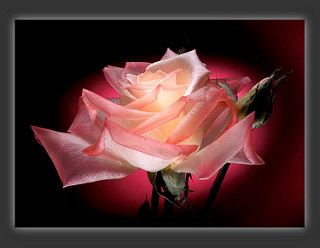

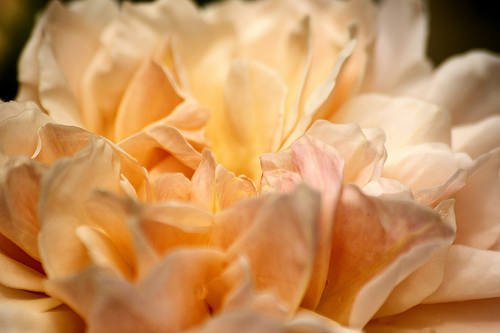

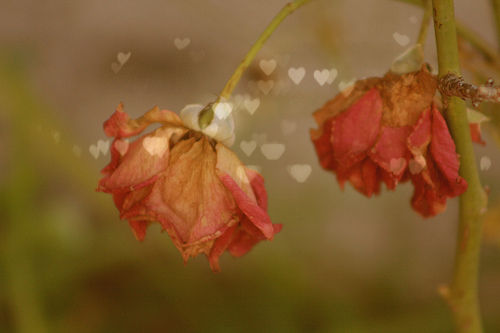

In [8]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
  display.display(Image.open(str(image_path)))

# Load the Image Dataset via `tf2.keras.preprocessing`

The first and convenient way to load the image dataset from a folder.

In [0]:
# convert the value to range [0,1]
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEP_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)

In [11]:
train_data_gen = image_generator.flow_from_directory(
    directory=str(data_dir), 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, 
    shuffle=True,
    classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


Let's inspect the batch image data.

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10, 10))
  for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(image_batch[i])
    plt.title(CLASS_NAMES[label_batch[i]==1][0].title())
    plt.axis('off')

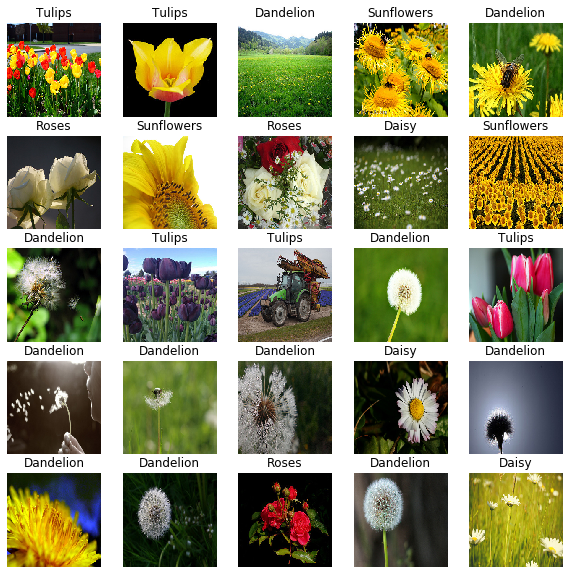

In [13]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

# Load the Image Dataset via `tf.data`

The second way to load the image dataset via the `tf.data` APIs. Unlike the first one, the latter one could increase the performance than the `tf.keras` APIs, and could provide more advanced integrations with Tensorflow.

To create a dataset of the file paths.

In [14]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
type(list_ds)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [15]:
for fp in list_ds.take(5):
  print(fp.numpy())

b'/root/.keras/datasets/flower_photos/tulips/112334842_3ecf7585dd.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/15108515192_f686dce398_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/452854574_59492f119a_m.jpg'
b'/root/.keras/datasets/flower_photos/tulips/5738195260_b3fc107aa7_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/16229215579_e7dd808e9c.jpg'


Write some pure Tensorflow functions to map the file path into an (image, label) pair.

In [0]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert a compressed string into a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, dtype=tf.float32)
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [0]:
def process_path(file_path):
  label = get_label(file_path)

  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

You can use `Dataset.map` to create a dataset of `image`, `label` pairs.

In [0]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [20]:
for image, label in labeled_ds.take(1):
  print("Image shape: {}".format(image.numpy().shape))
  print("Label: {}".format(label.numpy()))

Image shape: (224, 224, 3)
Label: [ True False False False False]


# Seetings for Training

To train a model over the dataset, several concepts are required to meet.

* To be well shuffled (balanced).
* To be batched.
* Batches are available as soon as possibile.

The following is an example to meet the above requirements.

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # use `.cache(filename)` to cache preprocessing work for datasets
  # that don't fit in memory
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # always repeat
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(labeled_ds)

In [0]:
image_batch, label_batch = next(iter(train_ds))

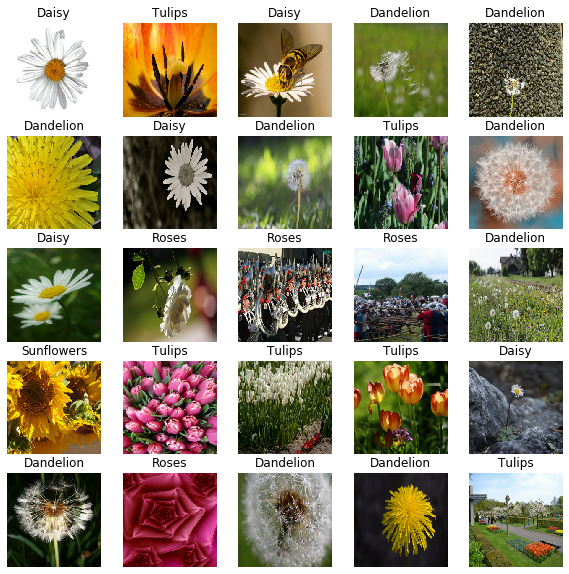

In [24]:
show_batch(image_batch.numpy(), label_batch.numpy())

# Performance

In [0]:
import time

In [0]:
def timeit(ds, steps=1000):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

Compare the time consume between the `tf.keras` APIs and the `tf.data` APIs.

In [51]:
# tf.keras
timeit(train_data_gen)

....................................................................................................
1000 batches: 86.24651217460632 s
371.02950 Images/s


In [52]:
# tf.data
timeit(train_ds)

....................................................................................................
1000 batches: 12.134353876113892 s
2637.14083 Images/s


The compare between `cache()` and `without cache()`.

In [0]:
uncached_ds = prepare_for_training(train_ds, cache=False)
timeit(uncached_ds)

In [0]:
filecached_ds = prepare_for_training(train_ds, cache='./flowers.tfcache')
timeit(filecached_ds)